# Astropy
*The Astropy Project is a community effort to develop a single core package for Astronomy in Python and foster interoperability between Python astronomy packages.*
http://www.astropy.org/

## Reading a fits file (spectrum)
We will read a fits file with a spectrum downloaded from the <a href="http://archive.eso.org/wdb/wdb/adp/phase3_spectral/form?phase3_collection=PESSTO&release_tag=3">ESO Phase3 archive of the PESSTO survey</a>.

In [1]:
from astropy.io import fits
hdus=fits.open("files/ADP.2017-08-24T09:39:15.889.fits")
tab=hdus[1].data
hdus.close()

# print info about the table columns
tab.columns


ColDefs(
    name = 'WAVE'; format = '950E'; unit = 'angstrom'
    name = 'FLUX'; format = '950E'; unit = 'erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'ERR'; format = '950E'; unit = 'erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'SKYBACK'; format = '950E'; unit = 'erg cm**(-2) s**(-1) angstrom**(-1)'
)

A simple example to make a basic plot of the data

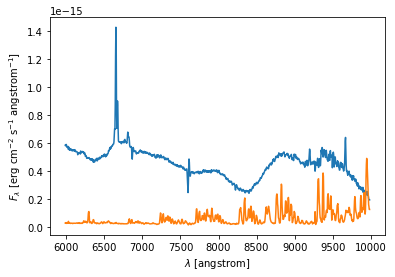

In [2]:
import matplotlib.pylab as plt
# this is required to have inline plots in the notebook
%matplotlib inline  

wave=tab[0]["WAVE"]
flux=tab[0]["FLUX"]
sky=tab[0]["SKYBACK"]

plt.plot(wave,flux);
plt.plot(wave,sky);
plt.xlabel("$\lambda$ [angstrom]");
plt.ylabel("$F_\lambda$ [erg cm$^{-2}$ s$^{-1}$ angstrom$^{-1}$]");

## Quantities and Units
<a href="http://docs.astropy.org/en/stable/units/">`astropy.units`</a> handles defining, converting between, and performing arithmetic with physical quantities

In [3]:
from astropy import units as u

l=84 *u.m
t=2*u.s
print (l)
print (t)

84.0 m
2.0 s


In [4]:
# you can make operations
speed=l/t
print(speed)

42.0 m / s


In [5]:
# and convert units
speed_kmh=speed.to(u.km/u.h)
print(speed_kmh)

151.2 km / h


## Coordinates

The <a href="http://docs.astropy.org/en/stable/coordinates/index.html">
`astropy.coordinates`</a> package provides classes for representing a variety of celestial/spatial coordinates and their velocity components, as well as tools for converting between common coordinate systems in a uniform way.

### Describing on-sky locations with `coordinates`

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

Let's use NGC 2403 to show how to use `SkyCoord`.

A `SkyCoord` object can be defined using directly the coordinates.
It's always wise to explicitly specify the frame your coordinates are in, although this is not strictly necessary because the default is ICRS.



If the object you're interested in is in [SESAME](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame), you can also look it up directly from its name using the `SkyCoord.from_name()` class method

In [7]:
# note that you have to specify the angle units!
coo1 = (SkyCoord(114.2141667*u.deg, 65.6025556*u.deg, frame='icrs'))

# using the object name
coo2 = SkyCoord.from_name('NGC2403')
# a different name for the same object
coo3 = SkyCoord.from_name("UGC3918")


print(coo1.to_string('hmsdms'))
print(coo2.to_string('hmsdms'))
print(coo3.to_string('hmsdms'))


07h36m51.4s +65d36m09.2002s
07h36m51.4001s +65d36m09.2016s
07h36m51.4001s +65d36m09.2016s


In [8]:
l = coo1.galactic.l.deg
b= coo1.galactic.b.deg
print ("Galactic coords: {0:.4f}, {1:+.4f}".format(l,b))

Galactic coords: 150.5691, +29.1858


In [9]:
# transform to FK4 (ep=B1950 eq=1950) frame
c_fk4 = coo1.transform_to('fk4')
print(c_fk4.to_string('hmsdms'))

07h32m02.3622s +65d42m50.5535s


## On-sky separation

In [10]:
c1=SkyCoord(10.12*u.deg, 20.32*u.deg, frame='icrs')
c2=SkyCoord(10.33*u.deg, 20.44*u.deg, frame='icrs')
sep = c1.separation(c2)
print (sep)
print ("in randians:",sep.rad)
print ("in degrees: ",sep.deg)
print ("in arcmins: ",sep.arcmin)

0d13m49.968s
in randians: 0.004023798592053551
in degrees:  0.23054667693535133
in arcmins:  13.83280061612108


# Astroquery + plots

## Get an image from VO 
https://skyview.gsfc.nasa.gov

In [11]:
from astroquery.skyview import SkyView

coo = SkyCoord(202.469575*u.deg, 47.195258*u.deg)
hdus=SkyView.get_images(position=coo,
                  survey=['SDSSg'],pixels=(600,600),
                          radius=.2*u.deg
                         )[0]

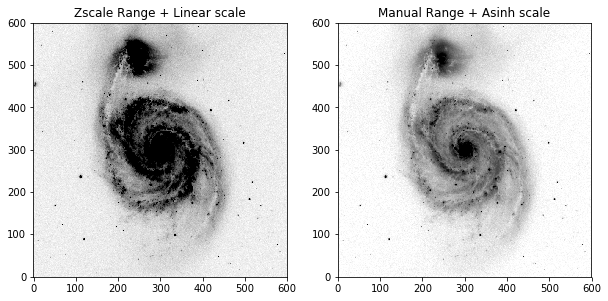

In [12]:
import matplotlib.pylab as plt
%matplotlib inline
import astropy.visualization as vis 
from astropy.wcs import WCS

data=hdus[0].data
wcs = WCS(hdus[0].header)

# plot using zscale
norm1 = vis.ImageNormalize(data, interval=vis.ZScaleInterval(),stretch=vis.LinearStretch())

# Asinh scale with user-defined cuts
z1=0.0
z2=2
norm2 = vis.ImageNormalize(vmin=z1, vmax=z2, stretch=vis.AsinhStretch())

fig,axes=plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(data,origin='lower',norm=norm1,cmap=plt.cm.gray_r)
axes[1].imshow(data,origin='lower',norm=norm2,cmap=plt.cm.gray_r)

axes[0].set_title("Zscale Range + Linear scale");
axes[1].set_title("Manual Range + Asinh scale");

# Download catalogue from Vizier

The following code will select the all stars in the <a href="http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=II/246">2MASS Point Source Catalog </a> brighter than Jmag=15 and with Photometric quality flag Qflg=AAA 

In [13]:
from astroquery.vizier import Vizier

# 2mass PSC is II/246 in vizier
v=Vizier(catalog="II/246",
        column_filters={'Jmag':"<15","Qflg":"AAA"})

# remove the limit to the number of output objects
v.ROW_LIMIT = -1

table = v.query_region(coo, radius=0.1*u.deg)[0]

print("Tot number or rows:",len(table))
for c in table.itercols():
    print ("Name: {0:10s} - {1}".format(c.name,c.description))
# show the first three rows
table[:3]


Tot number or rows: 19
Name: RAJ2000    - (ra) Right ascension (J2000)
Name: DEJ2000    - (dec) Declination (J2000) (dec)
Name: _2MASS     - (designation) Source designation (1)
Name: Jmag       - ?(j_m) J selected default magnitude (2)
Name: e_Jmag     - ?(j_msigcom) J total magnitude uncertainty (4)
Name: Hmag       - ?(h_m) H selected default magnitude (2)
Name: e_Hmag     - ?(h_msigcom) H total magnitude uncertainty (4)
Name: Kmag       - ?(k_m) K selected default magnitude (2)
Name: e_Kmag     - ?(k_msigcom) K total magnitude uncertainty (4)
Name: Qflg       - (ph_qual) JHK Photometric quality flag (5)
Name: Rflg       - (rd_flg) Source of JHK default mag (6)
Name: Bflg       - (bl_flg) JHK components fit to source (7)
Name: Cflg       - (cc_flg) Artifact contamination, confusion (8)
Name: Xflg       - [0,2] (gal_contam) Extended source contamination (10)
Name: Aflg       - [0,1] (mp_flg) Association with asteroid or comet (11)


RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,bytes17,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes3,bytes3,uint8,uint8
202.363149,47.170021,13292715+4710120,12.877,0.022,12.358,0.022,12.132,0.022,AAA,222,111,000,0,0
202.366275,47.156628,13292790+4709238,14.411,0.030,13.990,0.034,13.993,0.056,AAA,222,111,000,0,0
202.432416,47.153725,13294377+4709134,14.284,0.029,13.976,0.034,13.912,0.053,AAA,222,111,000,2,0


## Plot image + catalogue

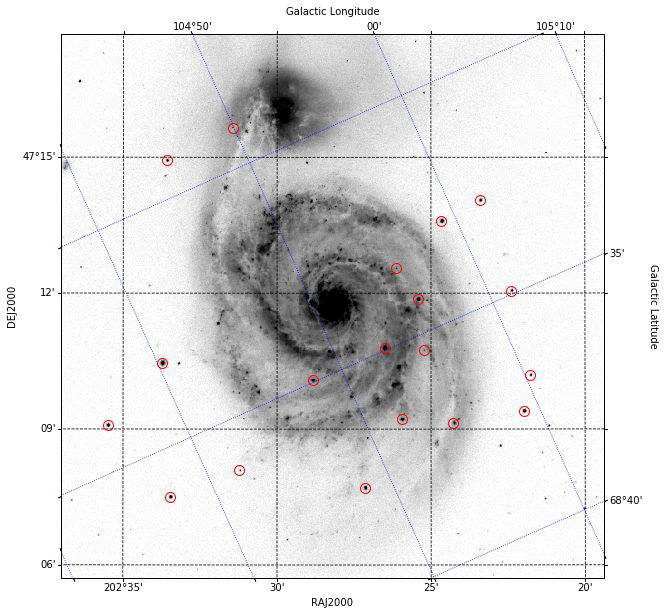

In [14]:
ra=table["RAJ2000"]
de=table["DEJ2000"]


fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection=wcs)
ax.imshow(data,origin='lower',norm=norm2,cmap=plt.cm.gray_r)

# RADEC grid
ax.coords.grid(True, color='black', ls='dashed')

# grid with Galactic coordinates
overlay_gal = ax.get_coords_overlay('galactic')
overlay_gal.grid(color='blue', ls='dotted')

# overplot 2MASS
ax.plot(ra, de, 'o',
            transform=ax.get_transform('world'),
            ms=10,mec='r',mfc='none')

overlay_gal[0].set_axislabel('Galactic Longitude')
overlay_gal[1].set_axislabel('Galactic Latitude')

ax.coords[0].set_axislabel('RAJ2000')
ax.coords[1].set_axislabel('DEJ2000')


# Cosmological Calculations 
The [`astropy.cosmology`](http://docs.astropy.org/en/stable/cosmology/) subpackage contains classes for representing cosmologies, and utility functions for calculating commonly used quantities that depend on a cosmological model. This includes distances, ages and lookback times corresponding to a measured redshift or the transverse separation corresponding to a measured angular separation.

In [15]:
from astropy.cosmology import FlatLambdaCDM

# In this case we just need to define the matter density 
# and hubble parameter at z=0.

# Note the default units for the hubble parameter H0 are km/s/Mpc. 
# You can also pass an astropy `Quantity` with the units specified. 

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


In [16]:
# age of the Universe at z=3
age_z3=cosmo.age(3)
print (age_z3)

2.112527190875782 Gyr


In [23]:
#number of transverse proper kpc corresponding to an arcminute at z=3:
kpc_arcm=cosmo.kpc_proper_per_arcmin(3)
print (kpc_arcm)


462.19848785184627 kpc / arcmin


In [24]:
# convert to kpc/arcsec
kpc_arcs=kpc_arcm.to(u.kpc/u.arcsec)
print (kpc_arcs)

7.703308130864104 kpc / arcsec


## plot using both the age of the Universe and redshift
We will plot the scale (kpc/arcsec) as a function of redshift.

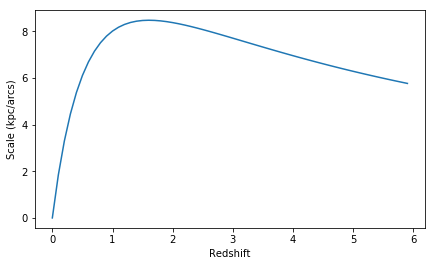

In [19]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
zvals = np.arange(0, 6, 0.1)
kpc_arcs=cosmo.kpc_proper_per_arcmin(zvals).to(u.kpc/u.arcsec)

fig,ax = plt.subplots(figsize=(7,4))
ax.plot(zvals, kpc_arcs)
ax.set_xlabel('Redshift')
ax.set_ylabel('Scale (kpc/arcs)');

Now we add an axis showing the Age of the Universe at different redshifts

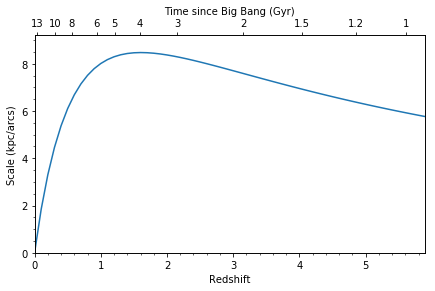

In [20]:
from astropy.cosmology import z_at_value

ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1.5, 1.2, 1])*u.Gyr
ageticks = [z_at_value(cosmo.age, age) for age in ages]

fig,ax = plt.subplots(figsize=(7,4))
ax.plot(zvals, kpc_arcs)

# axis for AGE
ax2 = ax.twiny()
ax2.set_xticks(ageticks)
ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])
# plots limits

zmin, zmax = 0, 5.9
ax.set_xlim(zmin, zmax)
ax2.set_xlim(zmin, zmax)

ax2.set_xlabel('Time since Big Bang (Gyr)')
ax.set_xlabel('Redshift')
ax.set_ylabel('Scale (kpc/arcs)')
ax.set_ylim(0, 9.2)
ax.minorticks_on()

# Two images with different WCS
We will plot an optical image of CenA and overplot radio contours from a VLA image.

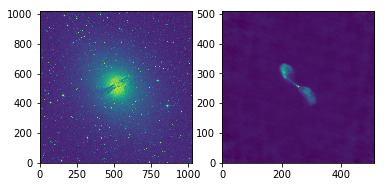

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


from astropy.wcs import WCS
from astropy.io import fits

fileRadio="files/VLA.fits"
fileOpt="files/NGC_5128_DSS_Red.fits"

hdus = fits.open(fileRadio)
wcsR = WCS(hdus[0].header)
imaR = hdus[0].data
hdus.close()

hdus = fits.open(fileOpt)
wcsO = WCS(hdus[0].header)
imaO = hdus[0].data
hdus.close()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(imaO,origin='lower')
ax2.imshow(imaR,origin='lower');

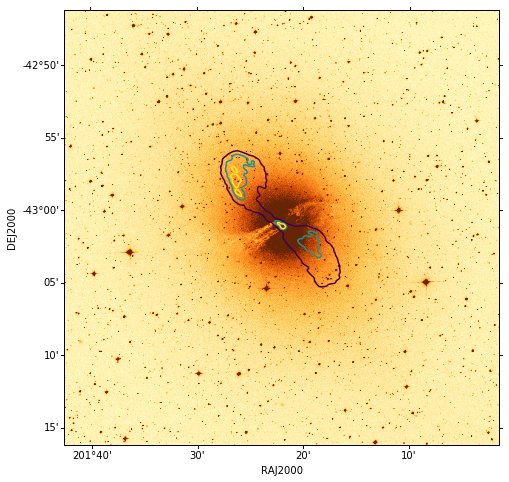

In [22]:

lvs=np.linspace(.4,3.,3)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection=wcsO)
ax.imshow(imaO,origin='lower',cmap=plt.cm.YlOrBr,vmin=11000,vmax=25000)
ax.autoscale(False)

ax.contour(imaR,levels=lvs,transform=ax.get_transform(wcsR))

ax.coords[0].set_axislabel('RAJ2000')
ax.coords[1].set_axislabel('DEJ2000')
